# Project 3: Reddit API & Subreddit Classification

This is the third project done as part of the General Assembly's Data Science Immersive in June 2021.

## Overview

Using the text classification capabilities of some machine learning models, we try to analyse data collected from a public website on two _similar but different_ topics, and train an algorithm which will classify the text as belonging to one or the other topic. This category of machine learning is known as NLP, or natural language processing, where a piece of code learns to understand the language we humans speak. This project is a very shallow dip into this field, in the sense that we use some very basic tools to achieve something impressive. The goal here is to classify a post from reddit correctly by predicting which subreddit it belongs to.


### Problem Statement

**To resolve a bet among a group of friends, who is more _creative_ $-$ [Filmmakers](https://www.reddit.com/r/Filmmakers/) or [Screenwriting](https://www.reddit.com/r/Screenwriting/)? To answer this question, we get some posts from the two subreddits from [reddit.com](https://www.reddit.com/), and see if we can differentiate between the two roles simply by analysing the text in the posts from the members of those subreddits.**

---

## Executive Summary

Creativity is a subjective phenomenon, which can mean different things to different people. For the purpose of this project, however, we make certain assumptions to answer our main problem statement, like, we will check posts from which role talks more about new ideas, or characters, or techniques, and so on. We begin by scraping the reddit website using its API for our data collection process, which is collecting as much text from the two subreddits, **Filmmakers & Screenwriting**, as possible. The reddit API limits the maximum number of posts one can scrape at a time, and given that we need unique posts, we aim to collect about 700~1000 unique posts for both subreddits.

Then we use simple techniques to extract useful text information from the posts, which is the _Title, Subreddit, and Selftext_ and save all this info into a CSV through a `pandas` DataFrame. Next, we perform some primitive cleaning steps to remove any symbols, urls, numbers that are not english character, because these don't provide us any useful information. The data we are looking for are words and phrases which can be used to describe the topics we are exploring.

After getting all this setup, we move to model building, where we train the _classification_ models from the `sklearn` library and then pass the posts to models to predict which subreddit it belongs to. Since any machine learning model can only take numbers as inputs, we use **bag-of-words** model to vectorize the text into a frequency table of each individual _token_ (or words) for the entire dataset. This is one of the simplest and widely used method, in which the number of times a word appears in the text is stored in a table.

There are many parameters which can be changed for the vectorizer and the model, that are tuned using the `Pipeline` and `GridSearchCV` methods to "search" for the best set of parameters to give good results. The results here are scored in terms of _accuracy_, which is the default score for all classification models in the `sklearn` library. An accuracy score is the ratio of the number of predictions the model got correct, over the total number of predictions it made. It is an easy-to-understand metric and for this project is a good measure of model performance to show at quick glance how many observations did we classify correctly, but might not give the complete understanding of the way the model behaves, especially when it comes to analysing the _misclassified_ data. The conclusions of how our model classifies the two roles of _Filmmakers & Screenwriting_ along with some recommendations are made at the end.

### Contents

The contents of this notebook are as follows:

- [1 Data import](#1-Data-import)
 - [1.1 Import libraries](#1.1-Import-libraries)
 - [1.2 Get the data](#1.2-Get-the-data)
- [2 Preprocessing text](#2-Preprocessing-text)
 - [2.1 Clean text](#2.1-Clean-text)
 - [2.2 Analyse text](#2.2-Analyse-text)
 - [2.3 Transform text](#2.3-Transform-text)
- [3 Building models](#3-Building-models)
- [4 Pipelines & parameter tuning](#4-Pipelines-&-parameter-tuning)
 - [4.1 Create pipelines](#4.1-Create-pipelines)
 - [4.2 Grid searching](#4.2-Grid-searching)
- [5 Evaluation](#5-Evaluation)
 - [5.1 Best Model](#5.1-Best-Model)
 - [5.2 Metrics](#5.2-Metrics)
 - [5.3 Misclassification](#5.3-Misclassification)
- [6 Conclusion and Recommendations](#6-Conclusion-and-Recommendations) 

## 1 Data import

As stated, we aim to collect about 700~1000 posts for each subreddit from the website, using the reddit API. We use `requests` package to scrape the posts in a loop to cheque unique posts and save it to CSV using the DataFrame. The data we get is in JSON object and we convert it to python dictionaries to extract the relevant info. Some tricks are used in the function so as to not overload the server requests sent from our machine.

**Note**: Some initialization variables are created to facilitate re-running of the code.

### 1.1 Import libraries

First we import the required libraries and packages.

In [1]:
# Data manipulation and support
import pandas as pd
import numpy as np
import requests
import random
import time
import os

# NLP and text processing
import regex as re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# sklearn transformers
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# sklearn models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# sklearn hyperparameter tuning and metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve

# plotting tools
import seaborn as sns
import matplotlib.pyplot as plt

# plotting settings
%matplotlib inline
# sns.set_style('whitegrid') # darkgrid
%config InlineBackend.figure_format = 'retina'

In [2]:
# plot font settings
# Implented plot text sizes from- https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#### Initialize variables

Let's initialize some control variables.

In [3]:
# A boolean flag to control whether or not to use local datasets
use_local_files = True

# List of subreddits (both of them have more than 1M followers and are active subreddits)
subreddits = ['Filmmakers', 'Screenwriting']

# create subreddit url
url = lambda x: f"https://www.reddit.com/r/{x}/.json"

# relative path to the datasets
file_path = lambda x: f"../datasets/{x}.csv"

#### Define functions

Create functions to handle the data scraping from reddit's API and save the data to csv.

In [4]:
# function to save the filtered posts to csv
def save_posts_csv(posts, sr):
    
    titles = []
    selftexts = []
    subreddits = []
    
    for idx in range(len(posts)):
        titles.append(posts[idx]['title'])
        selftexts.append(posts[idx]['selftext'])
        subreddits.append(posts[idx]['subreddit'])
        
    # Save the features into dictionary
    final_dict = {
        'Subreddit': subreddits,
        'Titles': titles,
        'Selftext': selftexts
    }
    
    if not os.path.exists(file_path(sr)):
        pd.DataFrame(final_dict).to_csv(file_path(sr), index=False)
    else:
        prev_posts = pd.read_csv(file_path(sr))
        current_df = pd.DataFrame(final_dict.values())
        pd.concat([prev_posts, current_df]).to_csv(file_path(sr), index=False)
    
    print(f"Saved {len(posts)} posts for {sr}")

In [5]:
# Get the subreddit data from reddit api, save unique posts to list and call save_posts_csv()
def get_reddit_posts(subreddit, num_posts=25, after=None):
    
    # while loop control variable
    run = 0
    
    unique_names = set()
    posts_collected = 0
    posts = []

    # Run a while loop until requested number of unique posts are collected
    while (posts_collected <= num_posts) and (run <= int(num_posts/25)):
        reddit_posts = []
        
        # change the user agent for each run
        headers = {'User-agent': f'Pony Inc 1.{run}'}
        
        # define the after which gets id of last subreddit in each request
        if after == None:
            params = {}
        else:
            params = {'after': after}
            
        # make request from reddit api
        res = requests.get(url(subreddit), params=params, headers=headers)

        # check for success
        if res.status_code != 200:
            print('Status error', res.status_code)
            break

        # get the json from result
        reddit_dict = res.json()
        
        # check each id and save only unique ones
        for post in reddit_dict['data']['children']:
            if post['data']['name'] not in unique_names:
                unique_names.add(post['data']['name'])
                reddit_posts.append(post['data'])
                posts_collected += 1

        posts.extend(reddit_posts)
        after = reddit_dict['data']['after']

        # generate a random sleep duration to look more 'natural'
        sleep_duration = random.randint(2,6)
        # print(sleep_duration, len(unique_ids), len(reddit_posts), after) # debug
        time.sleep(sleep_duration)
    
        # track number of runs to exit while loop
        run += 1

    # call the save_posts_csv() to save the data collected
    save_posts_csv(posts, subreddit)

### 1.2 Get the data

Use data either from reddit or the local saved files. Check the `use_local_files` flag above. Default is set to use local files, set to `False` to get new data.

In [6]:
# if not using local files, get from reddit
if not use_local_files:
    for sr in subreddits:
        get_reddit_posts(subreddit=sr, num_posts=1200)
else:
    try:
        pd.read_csv(file_path(subreddits[0]))
    except FileNotFoundError:
        for sr in subreddits:
            get_reddit_posts(subreddit=sr, num_posts=1200)
        
# read the data to Dataframes
df = pd.concat([pd.read_csv(file_path(subreddits[0])), pd.read_csv(file_path(subreddits[1]))])

## 2 Preprocessing text

Since this data is from a public webpage, it is not expected to be consistent. So, here we examine the data and address issues with missing values, removing the text which would not necessarily contribute to model building, that includes urls, numbers, punctuation marks etc. We do this to clean the data before vectorizing it into individual words and using it to train the models later. Additionally, we also binarize the target column to create the classification classes, _subreddit 1 & subreddit 2_.

**Note:** The subreddit topics are also removed from the text to remove any unique reference that can skew model classification results.

In [7]:
df.shape

(1722, 3)

In [8]:
df['Subreddit'].value_counts()

Screenwriting    982
Filmmakers       740
Name: Subreddit, dtype: int64

We have $1722$ observations in the dataframe consisting of titles, text, and which subreddit it belongs to for both subreddits. There are $982$ posts from **Screenwriting** subreddit and $740$ from **Filmmarkers**.

In [9]:
df.isna().sum()

Subreddit      0
Titles         0
Selftext     382
dtype: int64

Here we see that our dataset has $382$ missing values in the _Selftext_ column, which we can replace with an empty string, because these posts only have titles and no other text content.

In [10]:
# replace NaNs with empty string
df.fillna('', inplace=True)

After replacing all missing values with empty string, we can combine the title and the post text content into a single column, _Text_, which we will use as our feature for the modeling process. This is done to include:
- observations with missing text content
- titles as part of the modeling as well

In [11]:
# Combine title and selftext
df['Text'] = df['Titles'] + ' ' + df['Selftext']

#### Target distribution

The target disribution of the two subreddits in our dataset.

In [12]:
df['Subreddit'].value_counts(normalize=True) * 100

Screenwriting    57.026713
Filmmakers       42.973287
Name: Subreddit, dtype: float64

The ratio of $57 - 43$ can be considered as a _balanced_ class division, in that no one class significantly dwarfs the other. No extra steps need to taken for this dataset.

### 2.1 Clean text

Here, we clean the text and some of the steps are:
- Converting all text to lower case
- Remove the subreddit topic reference from the text
- Remove any urls
- Strip the data of punctuations
- Keep only text data and remove numbers
- Remove the common _stopwords_

In [13]:
# list of subreddit titles and related words to remove from text
ref_words = subreddits

In [14]:
# function to clean each document; carries out some common steps
def clean_document(doc, remove_stop_words=False):
    # convert all text to lowercase
    doc = doc.lower()
    
    # remove the subreddit name
    for w in ref_words:
        doc = doc.replace(w, '')
    
    # remove urls
    doc = re.sub(r'^https?:\/\/.*[\r\n]*', '', doc, flags=re.MULTILINE)
    
    # remove punctuation
#     doc = re.sub(r'[^\w\s]', '', doc)
    doc = re.sub(r'[^A-Za-z\w\s]+', '', doc)
    
    # remove numbers
    doc = re.sub(r'\d+', '', doc)
    
    # remove underscores
    doc = re.sub(r'_*', '', doc)
    
    # remove stopwords
    if remove_stop_words:
        doc = [word for word in doc.split() if word not in stopwords.words('english')]
        return ' '.join(doc)
    
    return doc

Clean the Text column.

In [15]:
df['Text'] = df['Text'].apply(clean_document)

Get a Target column which is `0: Filmmakers, 1: Screenwriting`.

In [16]:
df['Target'] = df['Subreddit'].apply(lambda x: 0 if x == subreddits[0] else 1)

### 2.2 Analyse text

Once cleaned, we can do some basic analysis on the text to gain some insights, which can be used to understand the results later. Knowing the text length distribution across the subreddit posts can be used, for example, to explain why certain post might be classified by our model correctly or incorrectly. This is because we use the **bag-of-words** model for this project, which essentially comes down to classifying correctly the set of words that belong to each class of the target variable.

Let's create a _clean_ DataFrame with target, text and text length columns.

In [17]:
df_clean = df[['Target', 'Text']].copy()
# let's remove the stop words in the clean DataFrame
df_clean['Text'] = df_clean['Text'].apply(clean_document, remove_stop_words=True)

df_clean['Text_length'] = df_clean['Text'].apply(lambda x: len(x.split()))

In [18]:
df_clean.sort_values(by='Text_length', ascending=False).head()

,Target,Text,Text_length
0,0,read asking question official filmmaking faq i...,2863
354,1,soho house short film contest content httpswww...,992
279,1,dont think theres ever acephobia script im mak...,820
150,0,young amateur film directorscreenwriter aiming...,763
104,1,young amateur film directorscreenwriter aiming...,750


The first post for target `0` is unually long and is supposed to be an intro to the subreddit, which is not a good datapoint to train our model on because we want our model to make good predictions on generalized data, we choose to drop this observation.

In [19]:
df.drop(0, inplace=True)
df_clean.drop(0, inplace=True)

In [20]:
df_clean[['Text_length']].describe().T

,count,mean,std,min,25%,50%,75%,max
Text_length,1720.0,52.800581,74.907329,1.0,16.0,33.0,61.0,992.0


The above table summarizes the statistics for the text length and we can see that $75\%$ of the posts have lengths upto 61 words per post and the mean length of posts is 52 words. Having longer posts, and in turn more data, would be useful to have a more reliable model but because of reddit API's limit we could only scrape so many unique posts at the time of this project.
 
Now, we plot distributions of text length for both the subreddits.

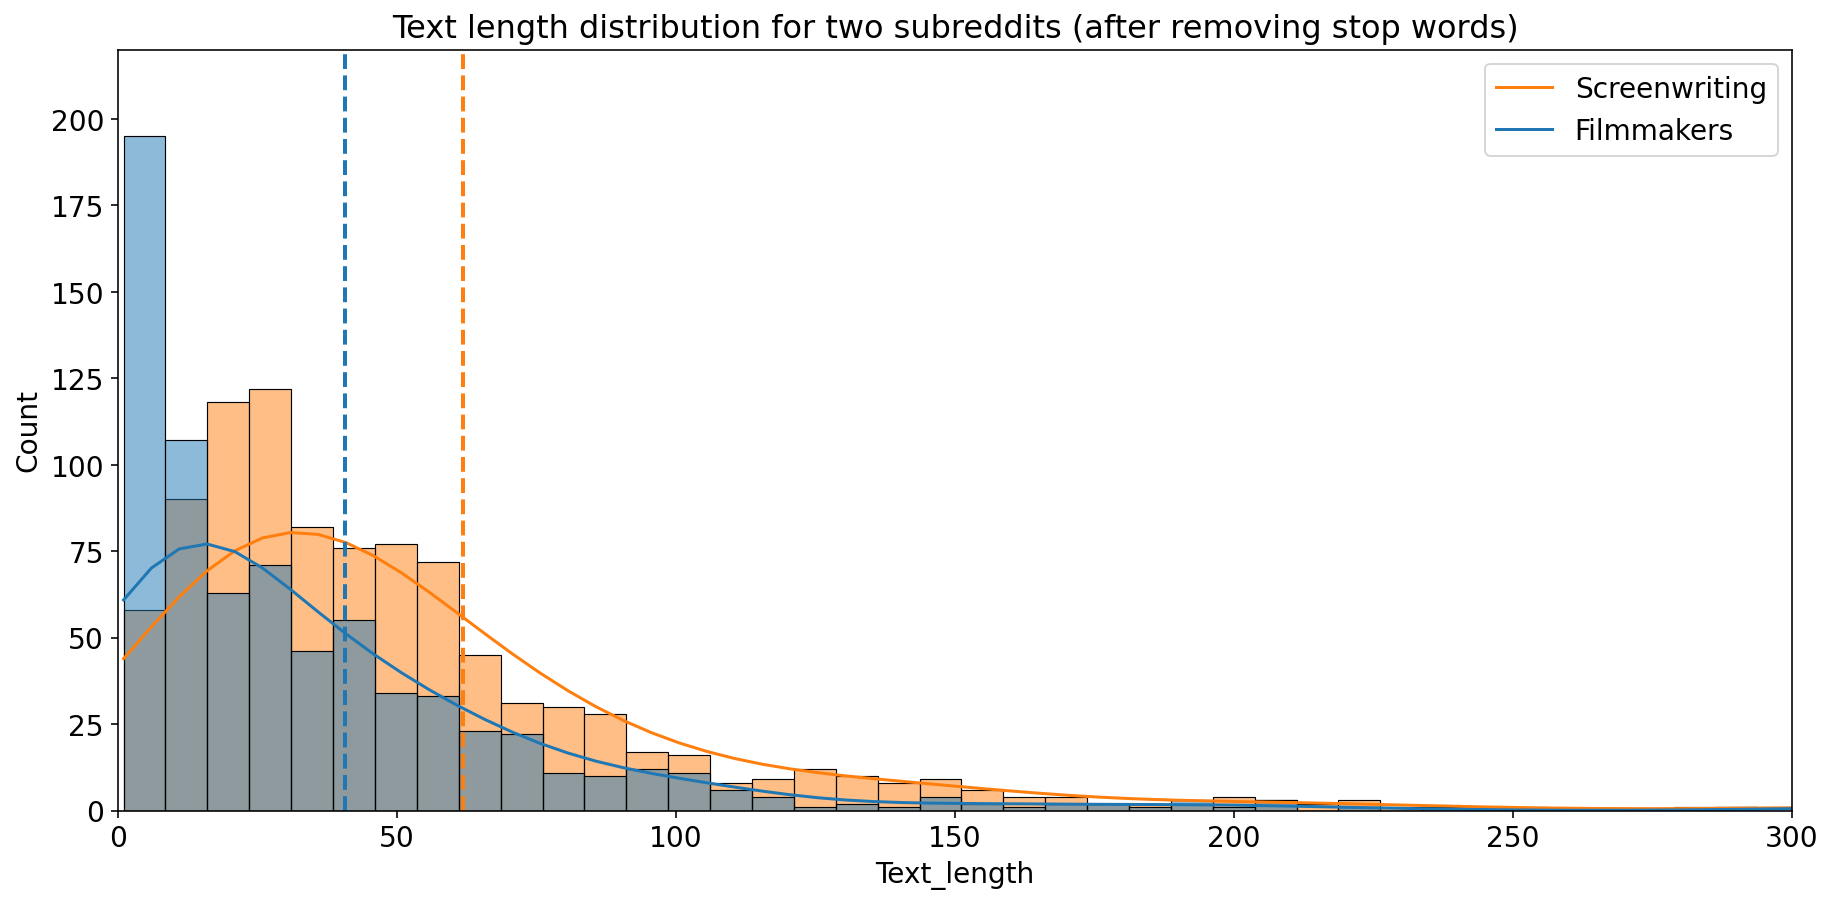

In [21]:
# plot the text length distributions for the posts
fig, ax = plt.subplots(figsize=(15, 7))
plt.title('Text length distribution for two subreddits (after removing stop words)')
sns.histplot(data=df_clean, x='Text_length', kde=True, hue='Target', ax=ax)
plt.legend(labels=[ subreddits[1], subreddits[0]])
mean_0 = df_clean[df_clean['Target']==0]['Text_length'].mean()
mean_1 = df_clean[df_clean['Target']==1]['Text_length'].mean()
plt.plot([mean_0, mean_0],[0, 250], '--', linewidth=2)
plt.plot([mean_1, mean_1],[0, 250], '--', linewidth=2)
plt.ylim([0, 220])
plt.xlim([0, 300]);

As we can see from the plot above, _after removing the common stop words_, posts from both subreddits are highly skewed to the right with mean text lengths of about $40$ for **Filmmakers** and about $62$ for **Screenwiters** subreddits.

Next, let's find the most common words in both subreddits. Here we use two techniques $-$ `CountVectorizer` and `TfidfVectorizer`. The former simply creates a frequency table for unique tokens for each document in the dataset while the latter is a bit more advanced where it penalizes the words that are too frequent across the dataset. Both of these are commonly used in the model building and thus we try both.

Listing the top words in both the subreddits should give us an idea of what is unique about the two topics. It can point us what _creativity_ means for two roles and if we can differentiate between them.

In [22]:
# Instantiate the text modification methods
cvec = CountVectorizer()
tvec = TfidfVectorizer()

**Filmmarkers**

In [23]:
com_wrds_s0 = pd.DataFrame(cvec.fit_transform(df_clean[df_clean['Target'] == 0]['Text']).todense(),
                               columns=cvec.get_feature_names())

In [85]:
# Top 10 most common words in Filmmakers subreddit
com_wrds_s0.sum().sort_values(ascending=False).head(20)

film       493
im         444
would      257
like       243
know       202
ive        191
short      186
get        177
want       176
make       168
one        146
dont       146
looking    145
camera     143
video      131
work       130
time       129
people     121
really     121
need       113
dtype: int64

In [25]:
# Save the common words from subreddit Filmmakers to csv
com_wrds_s0.sum().sort_values(ascending=False).to_csv(
                f'./../datasets/com_wrds_{subreddits[0]}.csv', header=['freq'])

Some of the most common words in the _Filmmakers_ subreddit posts after removing the stop words, like _film_, _make_ are also a direct reference to the subreddit topic and we should remove them.

In [26]:
ref_words.extend(['film', 'make'])

**Screenwriting**

In [27]:
com_wrds_s1 = pd.DataFrame(cvec.fit_transform(df_clean[df_clean['Target'] == 1]['Text']).todense(),
                               columns=cvec.get_feature_names())

In [28]:
# Top 10 most common words in Screenwriting subreddit
com_wrds_s1.sum().sort_values(ascending=False).head(20)

im          785
script      765
like        478
writing     462
would       419
ive         380
one         346
know        342
time        302
get         298
first       297
story       296
write       294
want        285
film        263
feedback    259
dont        259
anyone      248
read        228
also        219
dtype: int64

In [29]:
# Save the common words from subreddit Screenwriting to csv
com_wrds_s1.sum().sort_values(ascending=False).to_csv(
                f'./../datasets/com_wrds_{subreddits[1]}.csv', header=['freq'])

Similarly for the _Screenwriting_ subreddit posts, reference words like _script_, _writing_ can be removed.

In [30]:
ref_words.extend(['script', 'writing'])

#### Common words between the two subreddits

List the most frequently used words that are common between the two subreddits.

In [78]:
# create a dataframe with common words between the two subreddit posts
com_wrds_both = pd.concat([com_wrds_s0.sum(), com_wrds_s1.sum()], axis=1).dropna().astype('int')

In [90]:
com_wrds_both.sort_values(by=0, ascending=False).head(10)

,0,1
film,493,263
im,444,785
would,257,419
like,243,478
know,202,342
ive,191,380
short,186,191
get,177,298
want,176,285
make,168,208


In [91]:
com_wrds_both.sort_values(by=1, ascending=False).head(10)

,0,1
im,444,785
script,42,765
like,243,478
writing,37,462
would,257,419
ive,191,380
one,146,346
know,202,342
time,129,302
get,177,298


In [80]:
com_wrds_both.shape[0]

3582

In [32]:
print(com_wrds_s0.sum().shape[0], com_wrds_s1.sum().shape[0])

6185 9724


There are 3582 tokens that are common between the subreddits, and subreddits _Filmmakers and Screenwriting_ have 6185 and 9737 unique tokens, respectively. This essentially is the number of features that we will train our model on. Note that this only using the `CountVectorizer` method.

### 2.3 Transform text

Now, we can get the DataFrame and split the data into train and test sets. Even though we said the dataset can be considered balanced, we should specify `stratify = y` when splitting the data. We can use the default split ratio of $75-25$ for train-test. Then we transform them using the two vectorizers.

In [33]:
# Remove the extra reference words from the original dataframe
df['Text'] = df['Text'].apply(clean_document)

In [34]:
# get the features and target
X = df['Text']
y = df['Target']

In [35]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7, stratify=y)

In [36]:
X_train.shape[0]

1290

We have 1290 datapoints in our training data out of the original 1721.

In [37]:
# CountVectorize
# X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train).todense(), columns=cvec.get_feature_names())
# X_test_cvec = pd.DataFrame(cvec.transform(X_test).todense(), columns=cvec.get_feature_names())

X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

In [38]:
# TfidfVectorizer
# X_train_tvec = pd.DataFrame(tvec.fit_transform(X_train).todense(), columns=tvec.get_feature_names())
# X_test_tvec = pd.DataFrame(tvec.transform(X_test).todense(), columns=tvec.get_feature_names())

X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)

## 3 Building models

Now, lets build a few basic models using the different vectorizers.
We run three baseline default models $-$ _Logistic Regression, Multinomial Naive Bayes, and Support Vector Machine_ $-$ to see their performance and draw any insights if we can.

These models were selected as they are commonly used in binary classification problems. The Logistic Regression model is usually the easiest to interpret as it is an adapted version of a linear regression model. The coefficients of the features, after training, can be used to infer how much does it affects the prediction task. The Naive-Bayes algorithm is a simple probabilistic model that uses the _naive_ assumption that features are not correlated. Although, this does not have many control parameters, it still can produce good efficacy results when given "good" data. The third model, Support Vector Machine, is the most mysterious of them all, however, it does provide a few parameters which can be modified to achieve desired results.

#### Logistic Regression

In [39]:
lr_cvec = LogisticRegression(max_iter=500)
lr_cvec.fit(X_train_cvec, y_train)

LogisticRegression(max_iter=500)

In [40]:
lr_cvec.score(X_train_cvec, y_train)

0.9945736434108527

In [41]:
lr_cvec.score(X_test_cvec, y_test)

0.8604651162790697

**Note**: The `max_iter` had to be increased to 500 as the model was not converging.

In [42]:
lr_tvec = LogisticRegression()
lr_tvec.fit(X_train_tvec, y_train)

LogisticRegression()

In [43]:
lr_tvec.score(X_train_tvec, y_train)

0.9457364341085271

In [44]:
lr_tvec.score(X_test_tvec, y_test)

0.8627906976744186

The model performs well with both the vectorizers on the training data, too well actually, and the accuracy score for test data is not as high. This points to the fact that underneath the method is still a regression and using more features than required can cause the model to overfit to train data and underperform for test set. Overall, however, test accuracy of about 86% is not as bad, and we will look if we can improve the performance metrics later.

#### Naive-Bayes Classifier

In [45]:
nb_cvec = MultinomialNB()
nb_cvec.fit(X_train_cvec, y_train)

MultinomialNB()

In [46]:
nb_cvec.score(X_train_cvec, y_train)

0.9627906976744186

In [47]:
nb_cvec.score(X_test_cvec, y_test)

0.8116279069767441

In [48]:
nb_tvec = MultinomialNB()
nb_tvec.fit(X_train_tvec, y_train)

MultinomialNB()

In [49]:
nb_tvec.score(X_train_tvec, y_train)

0.8178294573643411

In [50]:
nb_tvec.score(X_test_tvec, y_test)

0.7023255813953488

The Naive-Bayes classification has unusual results as well, and since the model has limited control we suspect similar or worse results when tuning over hyperparameters with the vectorizers later in next section.

#### Support Vector Machines

In [51]:
svc_cvec = SVC()
svc_cvec.fit(X_train_cvec, y_train)

SVC()

In [52]:
svc_cvec.score(X_train_cvec, y_train)

0.8782945736434109

In [53]:
svc_cvec.score(X_test_cvec, y_test)

0.8046511627906977

In [54]:
svc_tvec = SVC()
svc_tvec.fit(X_train_tvec, y_train)

SVC()

In [55]:
svc_tvec.score(X_train_tvec, y_train)

0.9930232558139535

In [56]:
svc_tvec.score(X_test_tvec, y_test)

0.8697674418604651

The default SVC has relatively better score to Multinomial Naive-Bayes. This model, even thoguh widely used in classification problems, is the most black-box and least interpretable of the bunch.

All three models show signs of _overfitting_ when used with default transformer and model parameters, as the train accuracy score is significantly higher than the test score. 

## 4 Pipelines & parameter tuning

`Pipeline` is a great way to streamline the model building process for `sklearn` library. Here we can build multiple pipelines for various combinations of transformers and models we seek to explore and then use `GridSearchCV` to tune the hyperparameters.

### 4.1 Create pipelines

We add all the pipelines to a dictionary so we can iterate through it.

In [57]:
pipes_dict = {
    'pipe_lr_cvec': Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(max_iter=500))
    ]),
    'pipe_lr_tvec': Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(max_iter=500))
    ]),
    'pipe_nb_cvec': Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
    ]),
    'pipe_nb_tvec': Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
    ]),
    'pipe_svc_cvec': Pipeline([
    ('cvec', CountVectorizer()),
    ('svc', SVC())
    ]),
    'pipe_svc_tvec': Pipeline([
    ('tvec', TfidfVectorizer()),
    ('svc', SVC())
    ])
}

#### Pipeline parameters

Pipelines and GridSearchCV are a very convenient way to tune multiple parameters for the transformers and model at once. Some of the parameters we explore with the grid searching are:
- `max_features` $-$ maximum number of features included for model training
- `max_df` $-$ ignores the tokens that appeared in the given percentage of documents
- `min_df` $-$ a token has to appear in at least these many documents to be considered
- `ngram_range` $-$ single and double word combinations

A variety of these parameters gives the model building process some robustness when it comes to predicting new data. The overall accuracy score might not change a lot but the misclassification definitely improves as we see later. We want to minimize the `max_features` to avoid overfitting, as discussed above, and with `min_df` and `max_df` we can fine tune for different results. The stop words are the two generic ones from `NLTK` and `sklearn`.

In [58]:
pipe_cvec_params = {
    'cvec__max_features': [1000, 2000, 5000],
    'cvec__max_df': [0.3, 0.5, 0.8],
    'cvec__min_df': [2, 3, 5],
    'cvec__ngram_range': [(1, 1), (1, 2)],
    'cvec__stop_words': [stopwords.words('english'), 'english']
}

In [59]:
pipe_tvec_params = {
    'tvec__max_features': [1000, 2000, 5000],
    'tvec__max_df': [0.3, 0.5, 0.8],
    'tvec__min_df': [2, 3, 5],
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'tvec__stop_words': [stopwords.words('english'), 'english']
}

### 4.2 Grid searching

Using the pipelines created, we can now grid search over the parameters and find the seemingly optimal values. Then we can calculate the cross validated score , pick our model of choice and explore the results.

In [60]:
# Create a function to run the GridSearchCV for each pipe and store models in another dictionary
gs_dict = {}

def pipe_grid_search(pipe, pipe_params):
    vec = pipe.split('_')[2]
    model = pipe.split('_')[1]
    
    gs = f'gs_{model}_{vec}'
    gs_dict[gs] = GridSearchCV(estimator=pipes_dict[pipe], param_grid=pipe_params, cv=5)
    start = time.time()
    gs_dict[gs].fit(X_train, y_train)
    print(f"It took {time.time() - start} secs to run {gs} grid search.")

**Note**: The above function about several minutes to run when used with the following loop!!

In [61]:
# run a loop to iterate through the pipeline dictionaries
for pipe in pipes_dict.keys():
    if pipe.split('_')[2] == 'cvec':
        pipe_grid_search(pipe=pipe, pipe_params=pipe_cvec_params)
    elif pipe.split('_')[2] == 'tvec':
        pipe_grid_search(pipe=pipe, pipe_params=pipe_tvec_params)

It took 95.45984363555908 secs to run gs_lr_cvec grid search.
It took 80.5371766090393 secs to run gs_lr_tvec grid search.
It took 71.97186493873596 secs to run gs_nb_cvec grid search.
It took 72.53867673873901 secs to run gs_nb_tvec grid search.
It took 215.88156485557556 secs to run gs_svc_cvec grid search.
It took 231.44956874847412 secs to run gs_svc_tvec grid search.


Each loop is run $3 * 3 * 3 * 2 * 2 * 5 = 540$ times. The purpose here is to fit the models with training data and train them for different parameters and find the optimal values that gives us good scores.

## 5 Evaluation

Once training the models is done, we can look at the best parameters of each model trained and the respective scores. We can also look at the tokens that have the most effect on determining the prediction results and how posts can be misclassified.

In [62]:
# Write a function to print the results of the grid search. Add the results to a dictionary
def print_gs_results(gs):
    # train accuracy
    train_acc = round(gs_dict[gs].best_score_ * 100, 2)
    
    # cross val accuracy
    mean_cross_val_acc = round(cross_val_score(estimator=gs_dict[gs].best_estimator_,
                                         X=X_train,
                                         y=y_train,
                                         cv=10).mean() * 100, 2)
    
    # test accuracy
    test_acc = round(gs_dict[gs].score(X_test, y_test) * 100, 2)
    
    print(f"Results for {gs}'s best estimator")
    print("=============================================")
    print(f"Best score: {train_acc}  |  Cross validated score: {mean_cross_val_acc}")
    print(f"Test score: {test_acc}")

In [63]:
for gs in gs_dict.keys():
    print_gs_results(gs)
    print('\n')

Results for gs_lr_cvec's best estimator
Best score: 86.43  |  Cross validated score: 85.43
Test score: 85.12


Results for gs_lr_tvec's best estimator
Best score: 87.83  |  Cross validated score: 87.91
Test score: 86.05


Results for gs_nb_cvec's best estimator
Best score: 86.12  |  Cross validated score: 86.43
Test score: 82.09


Results for gs_nb_tvec's best estimator
Best score: 83.95  |  Cross validated score: 83.72
Test score: 83.72


Results for gs_svc_cvec's best estimator
Best score: 81.47  |  Cross validated score: 81.78
Test score: 83.49


Results for gs_svc_tvec's best estimator
Best score: 87.6  |  Cross validated score: 87.67
Test score: 84.65




Of all the models we trained over, all of them did a good job at preventing overfitting and not all models improved on the test accuracy score. Although, the test accuracy score is only one of the measures, we also printed the cross validated score calculated from the best model for each pipeline. The cross validated score is in general a better predictor of model performance in real life. For the purposes of this project, we do pick a model to get our results from.

### 5.1 Best model

Based on the scores above, let's select a model with a good cross validated score and low difference between train and test accuracy score, then we examine its predictions. This is not necessarily the best model overall, but with the data we have and the parameters we tune over, we can choose this as our production model.

In [64]:
# start by defining the best model
best_model = gs_dict['gs_lr_tvec']
best_model.best_estimator_

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.3, max_features=5000, min_df=2,
                                 stop_words='english')),
                ('lr', LogisticRegression(max_iter=500))])

For the results we obtain above, we chose the Linear Regression with TfIdfVectorizer transformer as our final model. Lets get the top features from this model that have the most predictive power in the classification. Our final model has 5000 `max_features`, `min_df` of 2, `max_df` of 0.3 (meaning words that appear in more than 30% of documents/posts are ignored).

In [65]:
# Get the feature names and respective coefficients 
feats = best_model.best_estimator_.named_steps['tvec'].get_feature_names()
coef = best_model.best_estimator_.named_steps['lr'].coef_.T

# put these two into a dataframe
feat_coef = pd.DataFrame([feats, coef], index=['features', 'coefficient']).T

To make a note that, the logistic regression is very straighforward to interpret because of the individual coefficients we get for each feature. These coefficients can be seen as "weights" that gives us their relative effect on the prediction output. These coefficients for a binary classification problem, case-in-point, like we get from our model have two parts:
- value: higher the value, bigger the impact on the prediction output
- sign: positive sign results in one class and negative sign results in the other class

Apart from apparent impact, the likelihood odds of that feature predicting the underlying class can also be calculated by taking it's exponential. Following are some of the top features that have highest impact in predicting the respective classes.

In [66]:
# features which have strong impact on predicting Filmmakers class
feat_coef.sort_values(by='coefficient').head(20)

,features,coefficient
506,camera,[-2.4294881440097167]
3533,short,[-2.1351494530132986]
2329,making,[-2.0974391724268306]
3346,rs,[-1.9288353934863804]
4210,videos,[-1.7562294437328345]
1056,director,[-1.5533177235475981]
4207,video,[-1.5114775388998412]
1178,editing,[-1.4503158726143905]
474,budget,[-1.439005820196425]
2537,music,[-1.2686621907521891]


Some of the **"creative"** words that we can pickup from the list above for the top features that help us predict the _Filmmakers_ class/subreddit are $-$ _camera, video, director, editing, music, production, lighting, shots, documentary, sound, commercial_. These are some of the topics people usually talk about that can be related to Filmmakers on the subreddit.

In [67]:
# features which have strong impact on predicting Screenwriting class
feat_coef.sort_values(by='coefficient', ascending=False).head(20)

,features,coefficient
4381,write,[2.9074942091104314]
3427,screenplay,[2.5380411802723093]
3423,screen,[2.2950615549694695]
2729,pages,[2.2472745195193298]
3117,read,[2.118221045492123]
4387,writers,[1.9469342972034962]
576,character,[1.9219014011314726]
1128,draft,[1.917031237405675]
2832,pilot,[1.8941297751799198]
4107,tv,[1.6999744702996062]


Similarly, the top **"creative"** words with highest impact on predicting the _Screenwriting_ class are $-$ _write, screeenplay, read, character, draft, pilot, feedback, story, idea, scene_ etc. These are some of the common things people post about screenwriting on the subreddit.

While both the classes have certain unique topics, quirks and words they talk about in the subreddits, they seemingly comprise of disparate "creative" words. Having said that, we need to see why the model accuracy is still not excellent, which we will look into in the next part.

The following table summarizes the __"creative"__ keywords from each class, with highest impact on the predictions.

| _Filmmakers_ | _Screnwriting_ |
|:------------:|:--------------:|
|camera, video, director, editing, music, production, lighting, shots, documentary, sound, commercial|write, screeenplay, read, character, draft, pilot, feedback, story, idea, scene|

### 5.2 Metrics

For a binary text classification task like this, mostly accuracy score is enough to examine the results. Maximising the model performance on this metric alone wouldn't be a bad idea, but as mentioned before, it only paints half the picture. To truly explore why the model behaves the way it does, some metrics that can help us understand our selected model's performance better are calculated here.

In [68]:
# write a function to plot the confusion matrix and ROC curve
def plot_cm_roc(model, X, y):
    roc_train = roc_auc_score(y_true=y_train, y_score=model.predict_proba(X_train)[:,1])
    roc_test = roc_auc_score(y_true=y, y_score=model.predict_proba(X)[:,1])
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,7))
    ax[0].set_title("Confusion Matrix for test data")
    ax[1].set_title("AUC ROC curve")
    plot_confusion_matrix(estimator=model,
                          X=X,
                          y_true=y,
                          cmap='Blues',
                          values_format='d',
                          colorbar=False,
                          ax=ax[0])
    plot_roc_curve(estimator=model, X=X_train, y=y_train, ax=ax[1])
    plot_roc_curve(estimator=model, X=X, y=y, ax=ax[1])
    ax[1].legend([f'train (AUC = {round(roc_train, 2)})', f'test  (AUC = {round(roc_test, 2)})']);

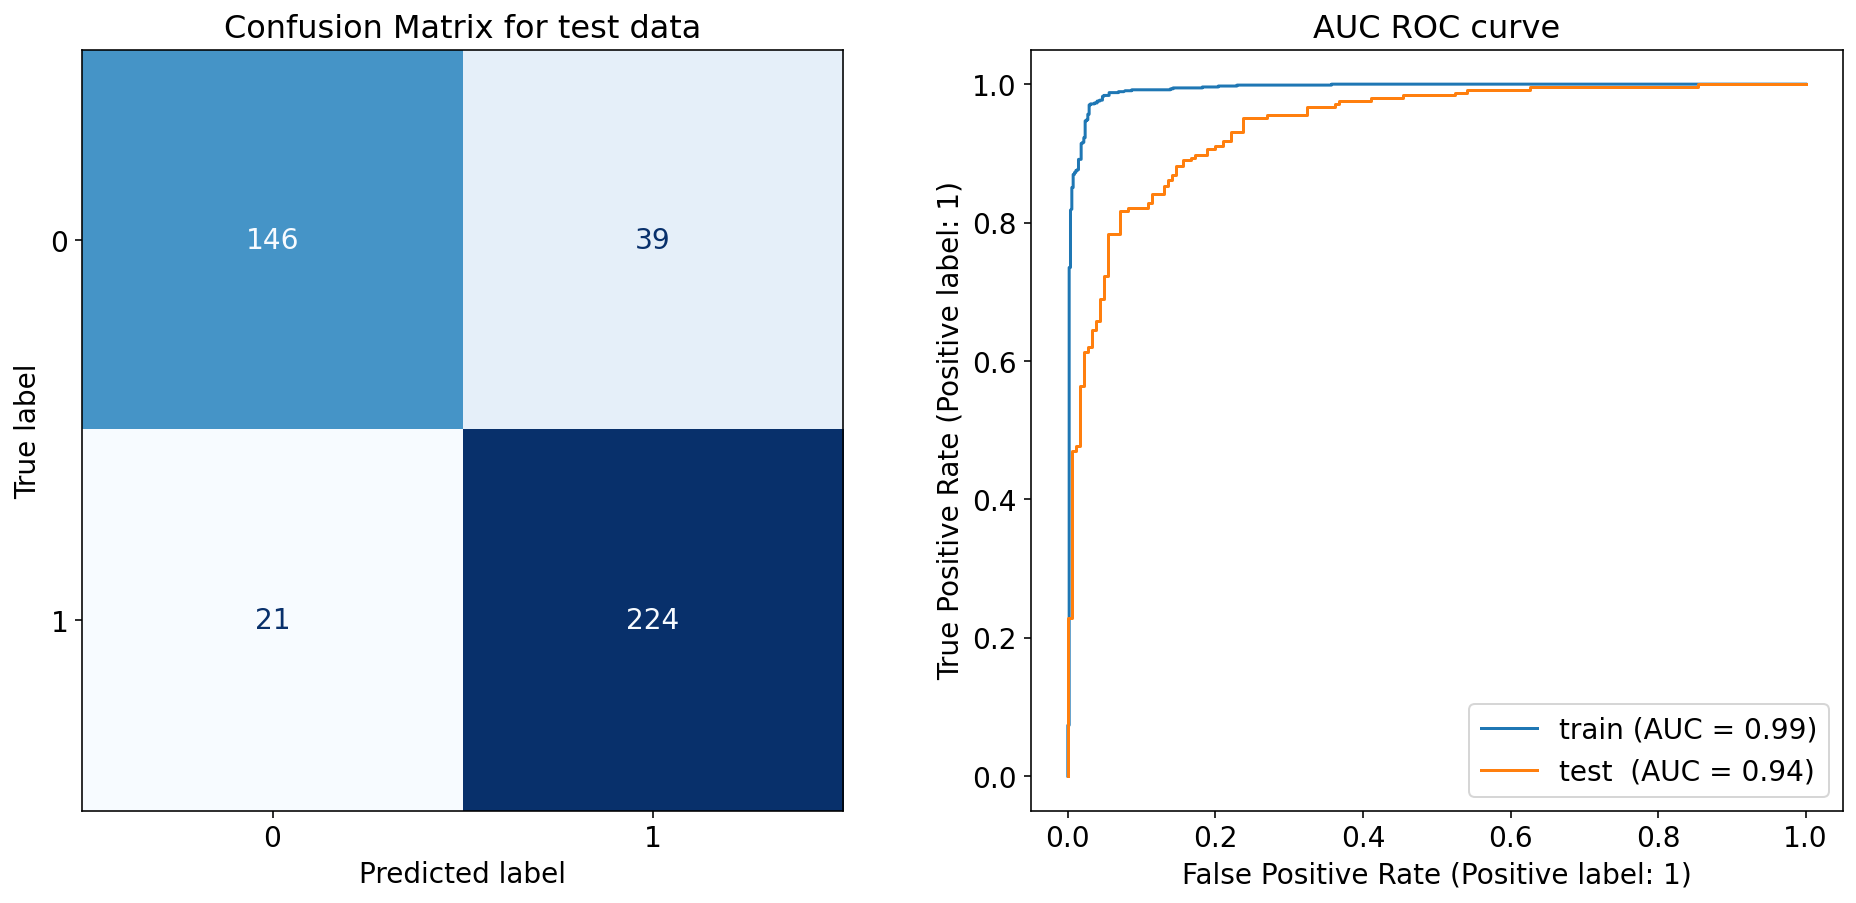

In [69]:
plot_cm_roc(best_model, X_test, y_test)

The two plots above show the confusion matrix and the ROC curve with AUC score for the test and train data. The first plot is a very common way to know the distribution of _correctness and wrongness_ of a model. The correctness is the number of observations in both classes, you predicted corretly, albeit there are two wrongness values $-$ _type I & type II_ errors, false positive & false negatives, respectively. The confusion matrix plots the predicted classes vs the actual classes. Metrics like sensitivity and specificity can be calculated from these values. The second plot is the ROC curve, which tells how good our model is at separating the two classes. The area under the curve (AUC) of 1 means the model can distinguish between the two classes perfectly. As you can see from our plot the model is good at differentiating between the two classes for test data but slightly better for train data.

In [70]:
cm = confusion_matrix(y_true=y_test, y_pred=best_model.predict(X_test))

In [71]:
tn, fp, fn, tp = cm.ravel()

In [72]:
sensitivity = (tp / (tp + fn))
sensitivity

0.9142857142857143

The sensitivity for our model is 0.91, means that out model is about 91% good at predicting the class 1, i.e., Screenwriting.

In [73]:
specificity = (tn / (tn + fp))
specificity

0.7891891891891892

The specificity for our model is 0.79, means that out model is about 79% good at predicting the class 0, i.e., Filmmakers.

### 5.3 Misclassification

There are 60 misclassifications in our test data out of 430 observations. Here, we will try to understand why a few of them were classified wrongly.

In [74]:
# get the predictions for the test data
preds = best_model.predict(X_test)

In [75]:
# create a dataframe with predicted and actual target
res = pd.DataFrame([preds, y_test], index=['predictions', 'actual']).T

In [76]:
# add two new columns to the dataframe: lenght of text and actual text for test data
res['length'] = X_test.map(lambda x: len(x.split())).values
res['text'] = X_test.values

In [77]:
# display the misclassified posts
res[res['predictions'] != res['actual']].head()

,predictions,actual,length,text
7,0,1,99,looking for indie production companies hi all ...
11,1,0,94,female director looking for work and feedback ...
12,1,0,12,motorcycles in anime the unlikely history behi...
16,1,0,73,term forexamples of ambient s with no characte...
31,1,0,83,planning on making a movie review sitecontent ...


Let's look at a few individual examples in detail and try to reason for the misclassification.

**Example 1:**

Look at the first datapoint in the list above, which originally belongs to _Screenwriting_ subreddit but was predicted to be from _Filmmakers_ subreddit. The original text from that post is:
> Hi all, I'm fairly new to this community and I apologize profusely in advance if this is the wrong place for my question. If that is the case, I'd appreciate any advice on where else to post it: I have a feature script that's intended for a relatively low budget indie production set in Florida. I am looking for resources or communities through which I can identify and contact indie producers/directors/production companies to pitch my script. Does anybody have any tips on where to find such resources? Thanks  in  advance for any advice/tips you can provide!!

This post starts by saying that the author is not sure of this post belongs to the correct place. Additionally, they talk more about the filmmaking process and use creative keywords like, directos, production, budget etc, which are listed as tokens more likely to predict this as belonging to _Filmmakers_ class.

**Example 2:**

The third post in the table above, has the following text in the post,
> Motorcycles in anime: The unlikely history behind Akira, Sailor Moon, and more!

Now this post belongs to _Filmmakers_ class but was classified as _Screenwriting_, but this is too short and therefore not enough features are captured. It could be possible that any of the other common words would tip the scales in other class's favor.

**Example 3:**

Let's look at another one from _Filmmakers_ class, the fifth post in the table. it says:

> Planning on starting a website where I will write film reviews! Was also thinking of hosting other reviewers and perhaps turning the website into a hub for content (including my own). Any tips, pointers or advice on the matter would be extremely helpful, especially if you’re experienced with this sort of thing.  If you have any interest in starting the site with me or being a future co-host on the site feel free to contact me!

At first glance, this post logically might or might not have to do anything with filmmaking but sure does inlcude a few of the creative keywords from the _Screenwriting_ class, like _writing, review_.

## 6 Conclusion and Recommendations

So, do we know who is more creative $-$ _Filmmakers or Screenwriting_? The short answer is _no_, but we do at least know what creative topics each group talks about and discussed with the community.

In this project, we used Reddit's API to scrape some posts from two subreddits, extracted relevant text info, cleaned and saved the data to analyse. We set out to see if we can figure out who is more creative between the two roles. We did some basic preprocessing of data and employed the _bag-of-words_ model to vectorize our text data into numbers that can be used to train the classification models.

Logistic Regression turned out to be the best estimator for this particular dataset we have in this project, along with the term frequency-inverse document frequency vectorizer. Our model had an accuracy of about 87% for train and 86% for test data. We can be satisfied with this result because we know we minimized the overfit and the gap between the train data (the data model was trained on) and test data (unseen data by model) is the smallest here. Also, among the two readily available stop words used in this project, the grid searching selected the `sklearn`'s in-built 'English' stop word list.

In total, there were about 60 misclassifications out of the 430 test data observations. The top features with highest preditive power for each class were identified and discussed. Each subreddit has its own set of disparate creative words that are unique to them but cannot be compared together. So, we conclude that we identified some keywords for both topics but are not sure who could be more creative.

Lastly, Logistic Regression does come with its caveats, like the assumption that the features have no/low multi-collinearity, the features have a linear relationship with the target variable, and generally it requires more data to capture the problem and even then it may not be able to build complex relationships. In the best model, according to grid search results, we use all the available tokens created by the vectorizer, and this is not a good choice because it may lead to overfitting with wider dataset. For these reasons, the other model used in this project, Multinomial Naive-Bayes, can give good results as well with a well-trimmed data. This can be looked into to improve the existing prediction capability.

We can make the following recommendations based on this conclusions:
1. We saw some plurals and words in different forms, which can be minimized by lemmatizing the text
2. Usually Decision Trees by themselves, if not parametrized properly, tend to overfit but used with boosting could be good classifiers, and can be used in this project.
3. Obtaining more data is always a good idea, but making "good" data by using more advanced text cleaning techniques can also be looked into.